# 1-import Data


In [1]:
import pandas as pd

In [2]:

cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID','PULocationID',
        'DOLocationID', 'payment_type', 'total_amount']

taxi_jan_2019 = pd.read_parquet('yellow_tripdata_2019-01.parquet', columns=cols)

# To add new data in the future
taxi_db = pd.concat([taxi_jan_2019])

# Data exploration

In [3]:
taxi_db.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,239,246,1,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,236,236,1,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,193,193,2,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,193,193,2,55.55


In [4]:
taxi_db.shape

(7696617, 9)

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'PULocationID'}>],
       [<Axes: title={'center': 'DOLocationID'}>,
        <Axes: title={'center': 'payment_type'}>,
        <Axes: title={'center': 'total_amount'}>]], dtype=object)

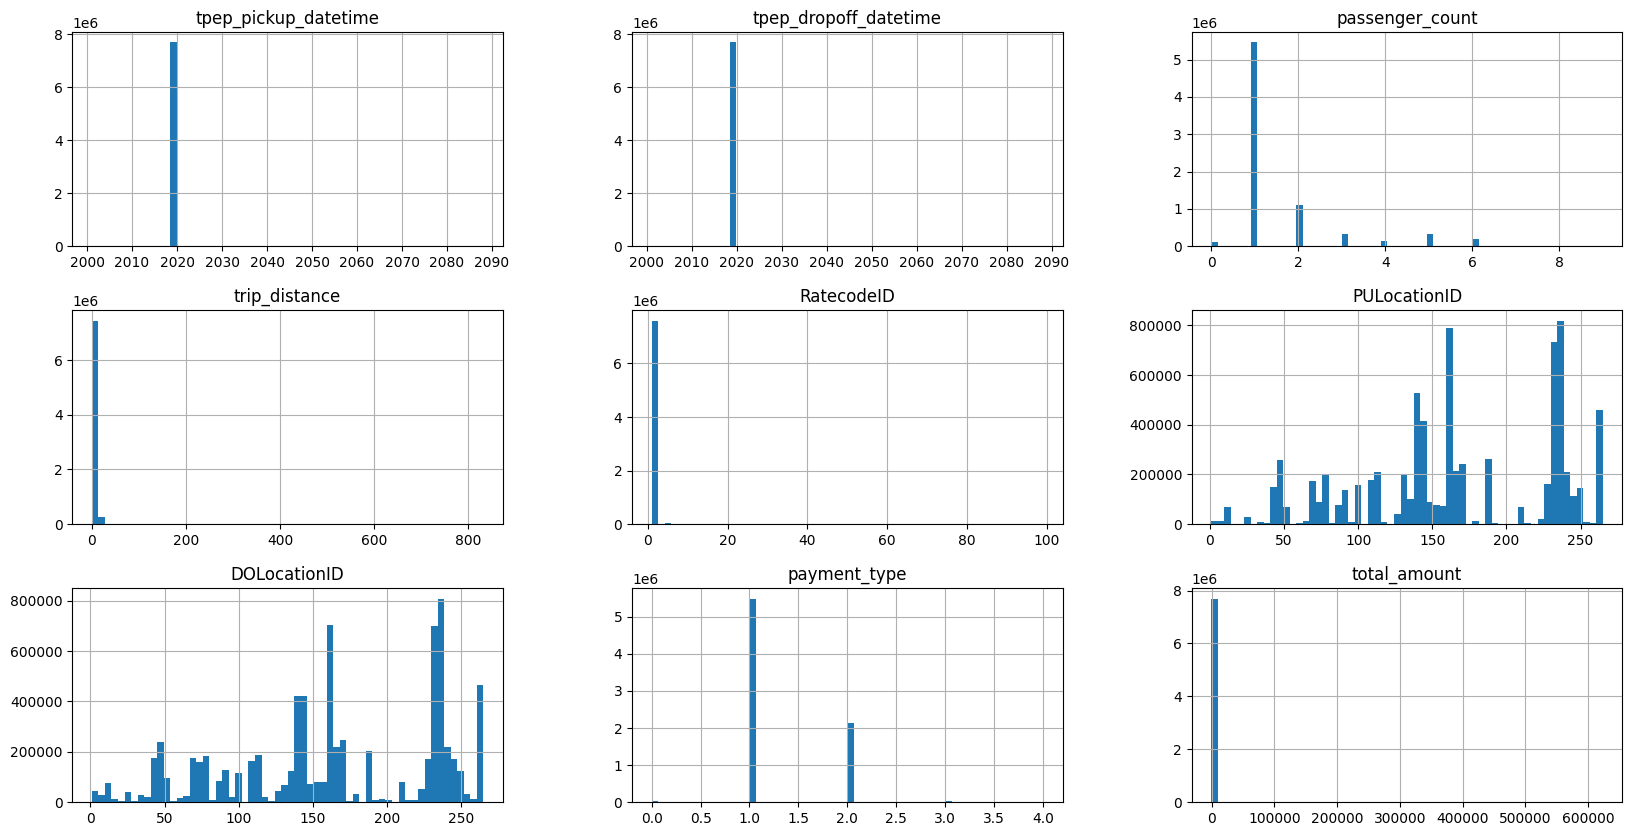

In [5]:
taxi_db.hist(figsize=(20,10), bins=60)

In [6]:
taxi_db['RatecodeID'].value_counts()


,count
RatecodeID,
1.0,7430288
2.0,166093
5.0,54570
3.0,11801
4.0,4895
99.0,252
6.0,46


<Axes: xlabel='index', ylabel='total_amount'>

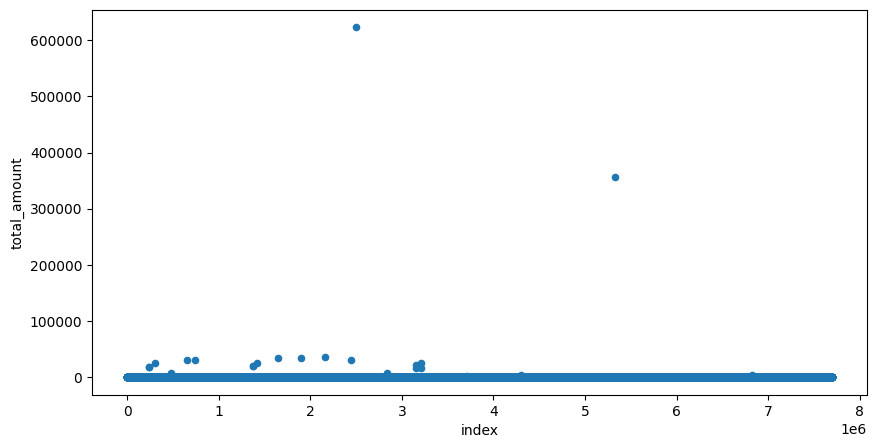

In [7]:
taxi_db.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

<Axes: xlabel='index', ylabel='total_amount'>

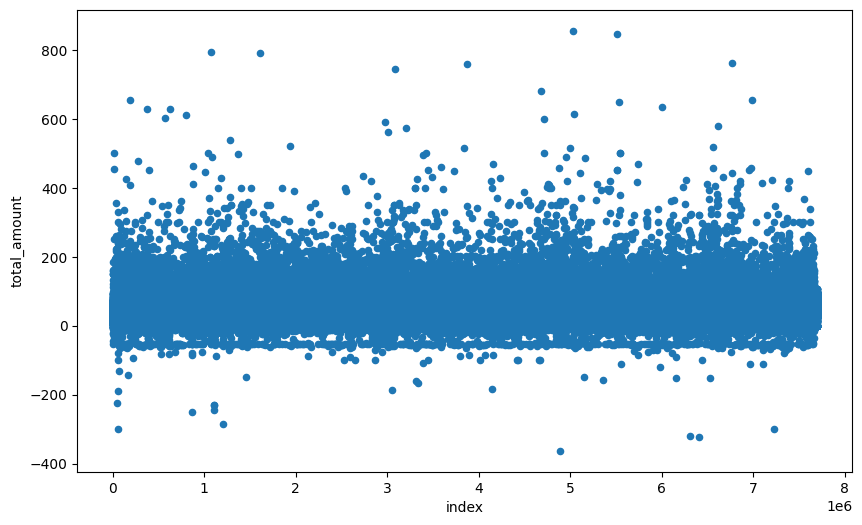

In [8]:
taxi_db[taxi_db['total_amount']<1000].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,6))

(7127, 9)


<Axes: xlabel='index', ylabel='total_amount'>

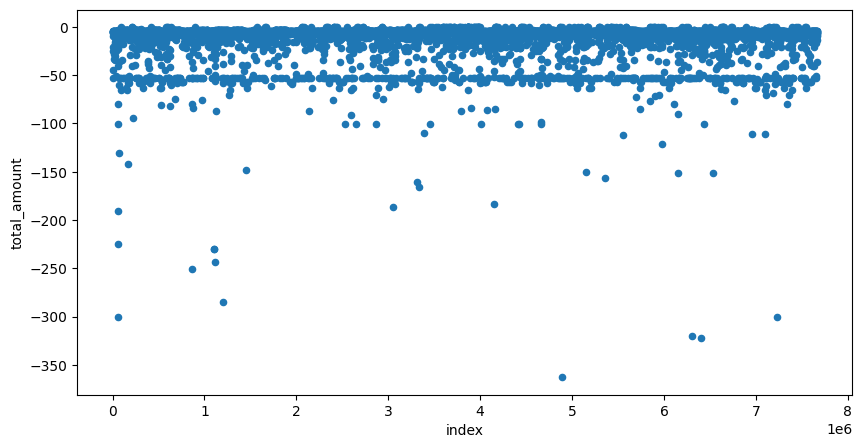

In [9]:
print(taxi_db[taxi_db['total_amount']<0].shape)
taxi_db[taxi_db['total_amount']<0].reset_index().plot(figsize=(10,5) ,kind='scatter', y='total_amount', x='index')

In [10]:
taxi_db[taxi_db['total_amount']<0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
663,2019-01-01 00:32:56,2019-01-01 00:33:35,2.0,0.10,1.0,148,148,3,-3.8
2402,2019-01-01 00:14:18,2019-01-01 00:40:55,1.0,4.13,1.0,170,238,4,-20.3
2541,2019-01-01 00:31:27,2019-01-01 00:42:39,1.0,1.35,1.0,162,234,4,-9.8
2544,2019-01-01 00:45:57,2019-01-01 00:46:07,1.0,0.00,1.0,234,234,4,-3.8
2547,2019-01-01 00:48:35,2019-01-01 00:49:59,1.0,0.16,1.0,234,234,4,-4.3


In [11]:
taxi_db[taxi_db['total_amount']<0]['payment_type'].value_counts()

,count
payment_type,
3,4083
4,2667
2,376
1,1


In [12]:
taxi_db[taxi_db['total_amount']==0].shape
taxi_db[taxi_db['total_amount']==0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
3552,2019-01-01 00:18:46,2019-01-01 00:18:46,1.0,0.0,5.0,186,264,2,0.0
9138,2019-01-01 00:41:47,2019-01-01 00:41:47,1.0,0.0,5.0,246,264,2,0.0
13256,2019-01-01 00:19:38,2019-01-01 00:20:35,1.0,0.0,1.0,193,193,1,0.0
13257,2019-01-01 00:43:34,2019-01-01 00:43:34,1.0,0.0,1.0,7,7,2,0.0
13258,2019-01-01 00:02:52,2019-01-01 00:02:52,1.0,0.0,1.0,264,7,2,0.0


In [13]:
taxi_db_prepared = taxi_db.copy()

In [14]:
taxi_db_prepared = taxi_db_prepared[(taxi_db_prepared['total_amount']>=0)&(taxi_db_prepared['total_amount']<200)]
taxi_db_prepared.dtypes


,0
tpep_pickup_datetime,datetime64[us]
tpep_dropoff_datetime,datetime64[us]
passenger_count,float64
trip_distance,float64
RatecodeID,float64
PULocationID,int64
DOLocationID,int64
payment_type,int64
total_amount,float64


In [15]:
taxi_db_prepared['trip_duration_min'] = (
    (taxi_db_prepared['tpep_dropoff_datetime'] -taxi_db_prepared['tpep_pickup_datetime']).dt.total_seconds()/60
)

taxi_db_prepared['trip_duration_min'] = taxi_db_prepared['trip_duration_min'].round(2)
print(taxi_db_prepared[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_duration_min']].head())


  tpep_pickup_datetime tpep_dropoff_datetime  trip_duration_min
0  2019-01-01 00:46:40   2019-01-01 00:53:20               6.67
1  2019-01-01 00:59:47   2019-01-01 01:18:59              19.20
2  2018-12-21 13:48:30   2018-12-21 13:52:40               4.17
3  2018-11-28 15:52:25   2018-11-28 15:55:45               3.33
4  2018-11-28 15:56:57   2018-11-28 15:58:33               1.60


In [16]:

taxi_db_prepared['transiction_year'] = taxi_db_prepared['tpep_pickup_datetime'].dt.year
taxi_db_prepared['transiction_month'] = taxi_db_prepared['tpep_pickup_datetime'].dt.month
taxi_db_prepared['transiction_day'] = taxi_db_prepared['tpep_pickup_datetime'].dt.day
taxi_db_prepared['transiction_hour'] = taxi_db_prepared['tpep_pickup_datetime'].dt.hour
taxi_db_prepared['transiction_date'] = taxi_db_prepared['tpep_pickup_datetime'].dt.normalize()


In [17]:
taxi_db_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,trip_duration_min,transiction_year,transiction_month,transiction_day,transiction_hour,transiction_date
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,151,239,1,9.95,6.67,2019,1,1,0,2019-01-01
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,239,246,1,16.30,19.20,2019,1,1,0,2019-01-01
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,236,236,1,5.80,4.17,2018,12,21,13,2018-12-21
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,193,193,2,7.55,3.33,2018,11,28,15,2018-11-28
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,193,193,2,55.55,1.60,2018,11,28,15,2018-11-28


array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>,
        <Axes: title={'center': 'trip_distance'}>],
       [<Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'PULocationID'}>,
        <Axes: title={'center': 'DOLocationID'}>,
        <Axes: title={'center': 'payment_type'}>],
       [<Axes: title={'center': 'total_amount'}>,
        <Axes: title={'center': 'trip_duration_min'}>,
        <Axes: title={'center': 'transiction_year'}>,
        <Axes: title={'center': 'transiction_month'}>],
       [<Axes: title={'center': 'transiction_day'}>,
        <Axes: title={'center': 'transiction_hour'}>,
        <Axes: title={'center': 'transiction_date'}>, <Axes: >]],
      dtype=object)

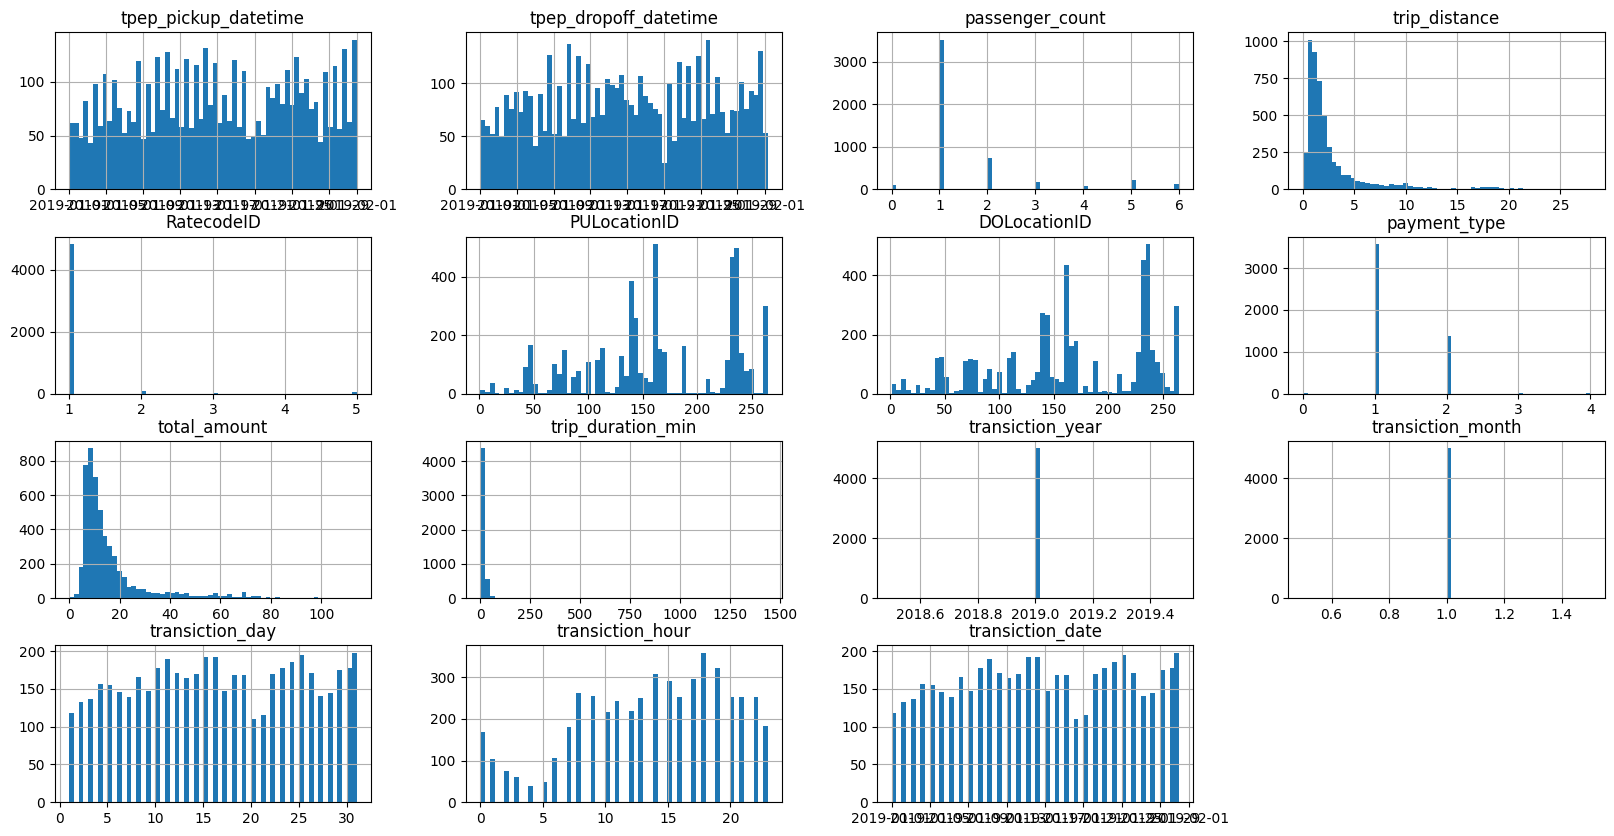

In [18]:
taxi_db_prepared.sample(5000).hist(figsize=(20,10), bins = 60)

In [19]:
taxi_db_prepared = taxi_db_prepared[taxi_db_prepared['transiction_year'] == 2019]
taxi_db_prepared = taxi_db_prepared[taxi_db_prepared['transiction_month'] == 1]

In [20]:
taxi_db_prepared.head()


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,trip_duration_min,transiction_year,transiction_month,transiction_day,transiction_hour,transiction_date
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,151,239,1,9.95,6.67,2019,1,1,0,2019-01-01
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,239,246,1,16.30,19.20,2019,1,1,0,2019-01-01
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1.0,1.3,1.0,163,229,1,9.05,7.15,2019,1,1,0,2019-01-01
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1.0,3.7,1.0,229,7,1,18.50,13.63,2019,1,1,0,2019-01-01
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2.0,2.1,1.0,141,234,1,13.00,12.00,2019,1,1,0,2019-01-01


In [21]:
from sklearn.preprocessing import LabelEncoder

categioral_columns = ['PULocationID', 'DOLocationID', 'payment_type']
date_cols = ['transiction_date', 'transiction_month', 'transiction_day', 'transiction_hour','trip_duration_min']

numerical_columns = ['trip_distance']
target = 'total_amount'
df_encoded= taxi_db_prepared[categioral_columns +date_cols+ numerical_columns+[target]].copy()

for col in categioral_columns:
  le= LabelEncoder()
  df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))


In [22]:
df_encoded.head()

,PULocationID,DOLocationID,payment_type,transiction_date,transiction_month,transiction_day,transiction_hour,trip_duration_min,trip_distance,total_amount
0,56,151,1,2019-01-01,1,1,0,6.67,1.5,9.95
1,153,159,1,2019-01-01,1,1,0,19.20,2.6,16.30
7,69,140,1,2019-01-01,1,1,0,7.15,1.3,9.05
8,142,228,1,2019-01-01,1,1,0,13.63,3.7,18.50
9,45,146,1,2019-01-01,1,1,0,12.00,2.1,13.00


In [23]:
taxi_grouped_by_region = df_encoded.groupby(categioral_columns).agg({
      'transiction_date': 'first',  # Take first date instead of averaging
    'transiction_day': lambda x: x.mode()[0],  # Most common day
    'transiction_hour': lambda x: x.mode()[0],  # Most common hour
    'trip_distance': 'mean',
    'total_amount': 'mean',
      'trip_duration_min': 'mean'
}).reset_index()
taxi_grouped_by_region['transiction_count'] = df_encoded.groupby(categioral_columns).count().reset_index()['total_amount']
print(taxi_grouped_by_region.shape)
taxi_grouped_by_region.head()

(68994, 10)


,PULocationID,DOLocationID,payment_type,transiction_date,transiction_day,transiction_hour,trip_distance,total_amount,trip_duration_min,transiction_count
0,0,0,1,2019-01-01,15,15,1.735486,103.387543,4.476343,350
1,0,0,2,2019-01-01,16,15,3.160652,60.378043,31.072826,46
2,0,0,3,2019-01-01,1,11,7.383333,16.922778,1.330556,18
3,0,0,4,2019-01-02,2,15,8.425000,23.805000,1.532500,4
4,0,34,1,2019-01-29,29,13,0.000000,71.400000,145.880000,1


<Axes: >

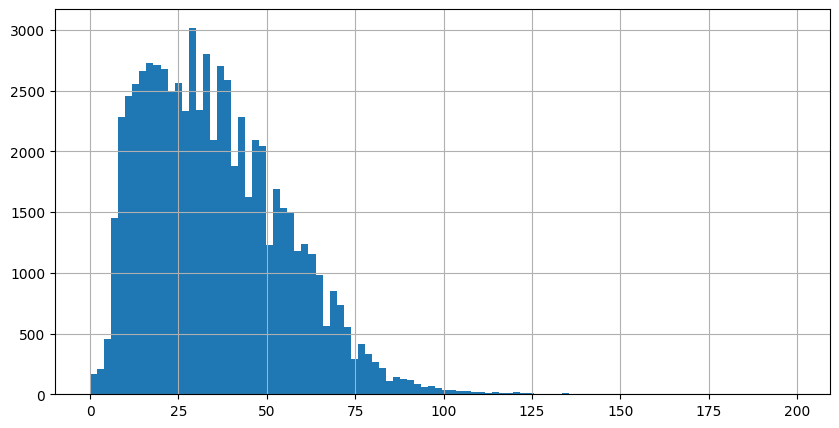

In [24]:
taxi_grouped_by_region['total_amount'].hist(bins=100, figsize=(10,5))


<Axes: >

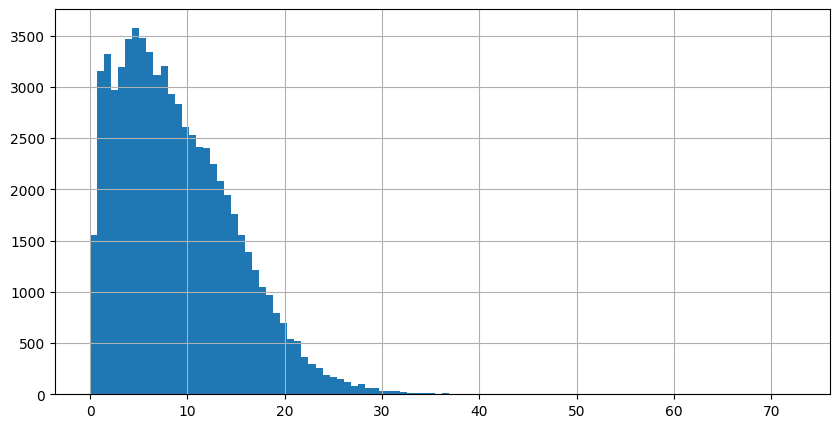

In [25]:
taxi_grouped_by_region['trip_distance'].hist(bins=100, figsize=(10,5))

In [26]:
from sklearn.model_selection import train_test_split
x = df_encoded[categioral_columns + numerical_columns]
y = df_encoded[[target]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)


In [27]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=15, min_samples_leaf=10)
tree.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=10)

In [28]:
model_at_hand = tree

y_pred = model_at_hand.predict(x_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error',mean_absolute_error(y_test,y_pred))
print('mean_squared_error',mean_squared_error(y_test,y_pred))
print('sqrt',sqrt(mean_squared_error(y_test,y_pred)))
print('r2_score',r2_score(y_test, y_pred))

mean_absolute_error 1.9027755716373744
mean_squared_error 16.30785980639947
sqrt 4.038299122947614
r2_score 0.911061782461436


In [29]:
# from sklearn.model_selection import GridSearchCV

# params = {
#     "max_depth" :[5,10,15,20],
#     "min_samples_leaf" : [1,5,10]
# }

# grid = GridSearchCV(DecisionTreeRegressor(), param_grid=params, cv=3)
# grid.fit(x_train,y_train)

# print("Best parameters:", grid.best_params_)

In [30]:
from sklearn.ensemble import RandomForestRegressor

x_sample = x_train.sample(300000,  random_state=42)
y_sample = y_train.loc[x_sample.index]
y_sample = y_sample.values.ravel()
# rf = RandomForestRegressor(max_depth=15, n_estimators=500,random_state=0 ,n_jobs=-1 )
# rf.fit(x_sample,y_sample)

# y_pred_rf = rf.predict(x_test)

# print(r2_score(y_test, y_pred_rf))

In [31]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# تدريب النموذج على كامل بيانات التدريب
hgb = HistGradientBoostingRegressor(
    max_iter=200,        # عدد التكرارات (مثل عدد الأشجار)
    max_depth=5,         # عمق الشجرة للحد من الأوفر فيتنق
    learning_rate=0.1,   # معدل التعلم
    random_state=0
)

# تدريب النموذج
hgb.fit(x_train, y_train)

# التنبؤ
y_pred_hgb = hgb.predict(x_test)
y_train_pred = hgb.predict(x_train)

# التقييم
r2 = r2_score(y_test, y_pred_hgb)
mae = mean_absolute_error(y_test, y_pred_hgb)
mse = mean_squared_error(y_test, y_pred_hgb)
rmse = np.sqrt(mse)

print(f"✅ R² score       : {r2}")
print(f"📉 MAE            : {mae}")
print(f"📉 MSE            : {mse}")
print(f"📉 RMSE           : {rmse}")

train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"🎯 Training R²     : {train_r2}")
print(f"🎯 Training RMSE   : {train_rmse}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


✅ R² score       : 0.9093642131122787
📉 MAE            : 1.9330706028525904
📉 MSE            : 16.61912895169908
📉 RMSE           : 4.076656589866147
🎯 Training R²     : 0.9099016273864377
🎯 Training RMSE   : 4.0711583291023725



## **Learning curve** to check if there is an **overfiting**

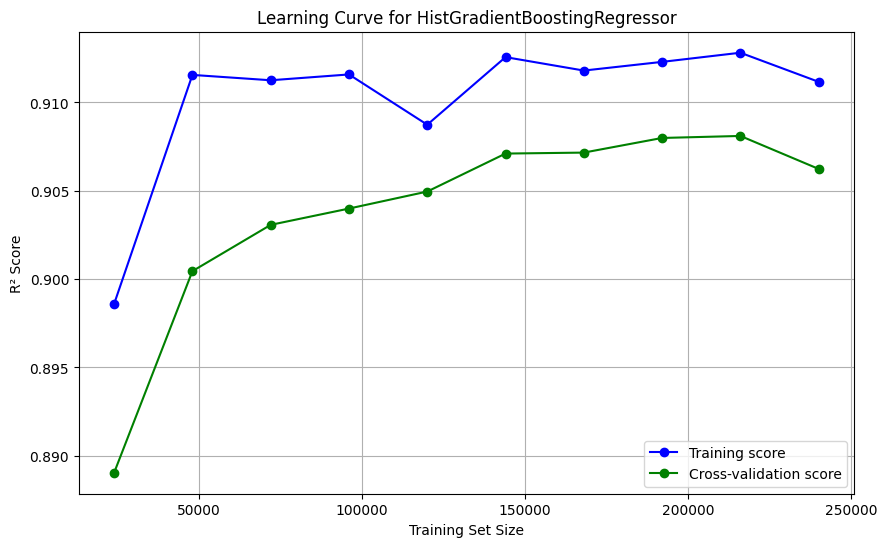

In [32]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np


train_sizes, train_scores, test_scores = learning_curve(
    hgb, x_sample, y_sample.ravel(),
    cv =5 ,
    scoring = 'r2',
    train_sizes = np.linspace(0.1,1.0,10),
    n_jobs=-1,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10,6 ))
plt.plot(train_sizes, train_scores_mean, '-o' , color='blue',label='Training score')
plt.plot(train_sizes, test_scores_mean, '-o' , color='green',label='Cross-validation score')
plt.title('Learning Curve for HistGradientBoostingRegressor')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()